/tmp/ipython-input-1017742710.py:14: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding="latin1")


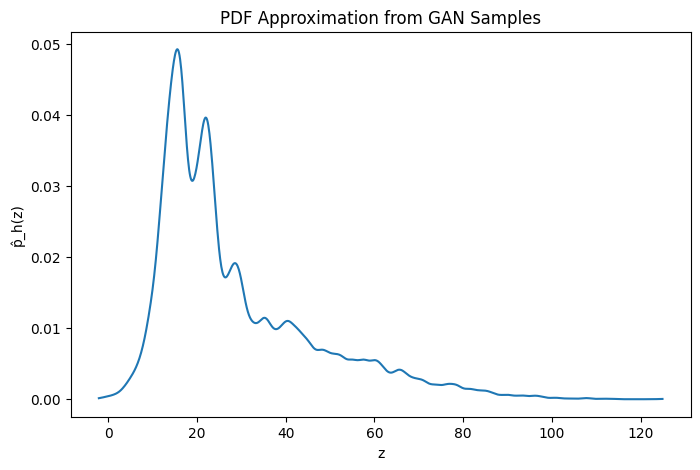

r = 102303806
a_r = 1.5
b_r = 0.6


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
import torch
import torch.nn as nn
import torch.optim as optim

r = 102303806
a_r = 0.5 * (r % 7)
b_r = 0.3 * (r % 5 + 1)

df = pd.read_csv("data.csv", encoding="latin1")

col = None
for c in df.columns:
    if "no2" in c.lower():
        col = c
        break

x = df[col].dropna().values.reshape(-1, 1)

z = x + a_r * np.arcsin(np.clip(b_r * x, -1, 1))
z = z[~np.isnan(z).any(axis=1)]

scaler = StandardScaler()
z_scaled = scaler.fit_transform(z)
z_tensor = torch.tensor(z_scaled, dtype=torch.float32)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.001)
optimizer_D = optim.Adam(D.parameters(), lr=0.001)

epochs = 2500
batch_size = 64

for _ in range(epochs):
    idx = np.random.randint(0, z_tensor.size(0), batch_size)
    real_samples = z_tensor[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    noise = torch.randn(batch_size, 1)
    fake_samples = G(noise)

    loss_D = criterion(D(real_samples), real_labels) + criterion(D(fake_samples.detach()), fake_labels)
    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

    noise = torch.randn(batch_size, 1)
    generated = G(noise)
    loss_G = criterion(D(generated), real_labels)
    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

with torch.no_grad():
    noise = torch.randn(10000, 1)
    z_f = G(noise).numpy()

z_f = scaler.inverse_transform(z_f)

kde = KernelDensity(kernel="gaussian", bandwidth=1.0).fit(z_f)
z_range = np.linspace(z_f.min(), z_f.max(), 1000).reshape(-1, 1)
p_h = np.exp(kde.score_samples(z_range))

plt.figure(figsize=(8,5))
plt.plot(z_range, p_h)
plt.xlabel("z")
plt.ylabel("p̂_h(z)")
plt.title("PDF Approximation from GAN Samples")
plt.show()

print("r =", r)
print("a_r =", a_r)
print("b_r =", b_r)